![](https://cdn.eleflow.com.br/ef-web/wp-content/uploads/2016/08/21181642/Eleflow.png)

# Introdução

O objetivo desse notebook é realizar um modelo de machine learning para prever a nota de um filme/serie caso fosse colocado no catálogo do Netflix.

# Sumário

* [1. Preparação do Ambiente](#preparacao)
    - [1.1. Bibliotecas](#biblotecas)
    - [1.2. Configurações](#configuracoes)
    - [1.3. Carregar Dados e Rápida Análise](#carregarDados)
* [2. Tratamento de Valores Faltantes](#valoresFaltantes)
* [3. EDA + Feature Engineering](#eda)
    - [3.1. Rating](#rating)
    - [3.2. Duration](#duration)
        - [3.2.1. TV Shows Duration](#series)
	- [3.2.2. Movies Duration](#movies)
    - [3.3. Type](#type)
    - [3.4. Country](#country)
    - [3.5. Listed/Genre](#genre)
    - [3.6. Director](#director)
    - [3.7. Cast](#cast)
    - [3.8. Release Year & date Added](#release)
    - [3.9. Title & Description](#title)
* [4. Remoção de Variáveis](#remocao)
* [5. Correlação](#correlacao)
* [6. Modelagem](#modelagem)
    - [6.1. Divisão do Dataset](#split)
    - [6.2. Redução de Dimensionalidade](#dimensionalidade)
    - [6.3. Previsão](#previsao)
* [7. Resultados](#resultados)
* [8. Otimização de Hiperparâmetros](#otimizacao)
* [9. Possíveis Melhorias](#melhorias)

<a id="preparacao"></a>
# 1. Preparação do Ambiente

<a id="bibliotecas"></a>
## 1.1. Bibliotecas

In [59]:
# Principais bibliotecas
import numpy as np
import pandas as pd

# Visualização de dados
from matplotlib import pyplot as plt
import seaborn as sns

# Previsão
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Utilidades e outras
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from scipy.stats import kurtosis, skew
import utils
import warnings

<a id="configuracoes"></a>
## 1.2. Configurações

In [60]:
# Esconder os warnings
warnings.filterwarnings("ignore")

# Mostrar linhas, colunas e textos completos
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', False)

<a id="carregarDados"></a>
## 1.3. Carregar Dados e Rápida Análise

Com base nas informações abaixo, já podemos observar que a variável que nosso target será a variável "rating".

O dataset possui muitas variáveis com diversos elementos inclusos (como por exemplo a variável "country" possui diversos países em apenas um registro). Essas variável terão que ser analisadas e tratadas.

In [61]:
df = pd.read_excel("../data/dataset_netflix.xlsx")
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole Howard, Jennifer Cameron, Jonathan Holmes, Lee Tockar, Lisa Durupt, Maya Kay, Michael Dobson","United States, India, South Korea, China",2019-09-09,2019.0,41.0,90 min,"Children & Family Movies, Comedies","Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first."
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,52.0,94 min,Stand-Up Comedy,"Jandino Asporaat riffs on the challenges of raising kids and serenades the audience with a rousing rendition of ""Sex on Fire"" in his comedy show."


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       6234 non-null   int64         
 1   type          6234 non-null   object        
 2   title         6234 non-null   object        
 3   director      4264 non-null   object        
 4   cast          6233 non-null   object        
 5   country       6233 non-null   object        
 6   date_added    6222 non-null   datetime64[ns]
 7   release_year  6233 non-null   float64       
 8   rating        6233 non-null   float64       
 9   duration      6233 non-null   object        
 10  listed_in     6233 non-null   object        
 11  description   6233 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 584.6+ KB


<a id="valoresFaltantes"></a>
# 2. Tratamento de Valores Faltantes

Uma primeira notícia boa é que não temos muitos valores faltantes (com exceção da variável "director", como já podemos observar na tabela abaixo.

In [63]:
utils.get_missing(df)

,Total,%
director,1970,31.6
date_added,12,0.2
cast,1,0.0
country,1,0.0
release_year,1,0.0
rating,1,0.0
duration,1,0.0
listed_in,1,0.0
description,1,0.0


Antes de qualquer coisa, observando a linha que possui o target como nulo, vemos que praticamente todas as outras colunas também são nulas. Vou apenas excluir essa linha do dataset, já que ela não terá utilidade.

In [64]:
df[df["rating"].isnull()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
2017,80119194,Movie,The Memphis Belle: A Story of a,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [65]:
df = df[df.rating.notnull()]

Para a variável "director", vamos preencher com um mesmo valor para todos os registros

Para a variável de "date_added", o preenchimento com a moda já é suficiente e corrige nosso problema.

In [66]:
df["date_added"].fillna(df['date_added'].mode()[0], inplace = True)
df["director"].fillna("No Director", inplace = True)

Nosso dataset agora não tem mais valores faltantes e, portanto, podemos começar com a análise das variáveis.

In [67]:
utils.get_missing(df)

,Total,%


<a id="eda"></a>
# 3. EDA + Feature Engineering

<a id="rating"></a>
## 3.1. Rating

A primeira variável a ser analisada será o target. No gráfico abaixo podemos observar alguns pontos:
* Uma grande concentração de valores iguais a 0.
* Não temos quase nenhum valor entre 0 e 20.
* A distribuição dos dados tem praticamente uma curva normal

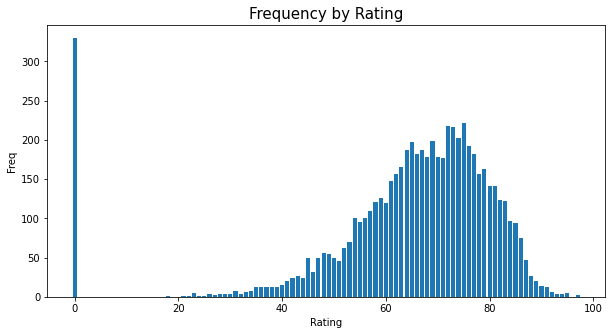

In [68]:
df_plot = df["rating"].value_counts().rename_axis('Rating').reset_index(name='Frequency')

fig = plt.figure(figsize = (10, 5))
plt.bar(df_plot["Rating"], df_plot["Frequency"])
plt.xlabel("Rating")
plt.ylabel("Freq")
plt.title("Frequency by Rating", fontsize=15)
plt.show()

Conferindo a assimetria e curtose da distribuição, podemos chegar a conclusão que não será necessária um ajuste da variável.

In [69]:
df = df[df["rating"] != 0]

print(f'Kurtosis: {kurtosis(df["rating"])}')
print(f'Skewness: {skew(df["rating"])}')

Kurtosis: 0.33428528566910254
Skewness: -0.6104825108864256


In [70]:
# Cópia do dataset para manter o original
df_eda = df.copy()

<a id="duration"></a>
## 3.2. Duration

A variável "duration" possui dois tipos de duração: para seriados e para filmes. Enquanto os filmes tem minutagem, os seriados são contados por temporada. Por essa razão, separarei o dataset em dois nessa parte.

In [71]:
df_eda["duration"].value_counts().head(10)

1 Season     1190
2 Seasons    291 
3 Seasons    155 
90 min       108 
91 min       101 
92 min       97  
95 min       93  
94 min       92  
99 min       88  
93 min       87  
Name: duration, dtype: int64

In [72]:
df_min = df_eda[df_eda["duration"].astype(str).str.contains(" min")]
df_min["duration"] = df_min["duration"].replace(" min", "", regex=True)
df_min["duration"] = df_min["duration"].astype(int)

df_season = df_eda[df_eda["duration"].astype(str).str.contains(" Season")]
df_season["duration"] = df_season["duration"].replace(" Season", "", regex=True)
df_season["duration"] = df_season["duration"].replace("s", "", regex=True)
df_season["duration"] = df_season["duration"].astype(int)

<a id="series"></a>
### 3.2.1. TV Shows Duration

Apesar de não ser tão forte, já podemos ver um primeiro comportamento linear entre a quantidade de temporadas e o rating da série.

Isso parece ser um pouco óbvio para mim: se uma série foi filmada por tanto tempo, provavelmente ela foi boa. É necessário um grande investimento para manter uma série na TV, e isso só é possível com uma grande audiência.

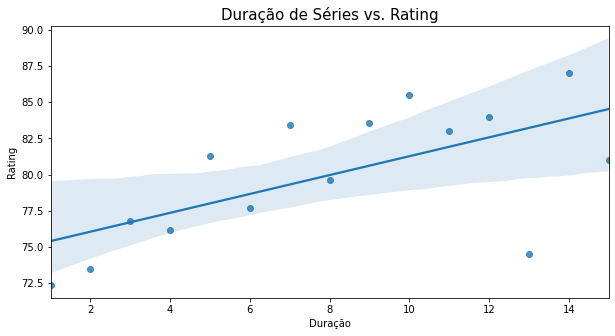

In [73]:
df_plot = utils.get_rating_by_element(df_season, "duration")

plt.figure(figsize=(10, 5))
sns.regplot(data=df_plot, x='duration', y="rating")
plt.title("Duração de Séries vs. Rating", fontsize=15)
plt.xlabel("Duração")
plt.ylabel("Rating")
plt.show()

Para padronizar a variável, podemos normalizar a variável, criando um intervalo de 0 a 1.

In [74]:
scaler = MinMaxScaler()
df_season["duration"] = scaler.fit_transform(df_season[["duration"]])

<a id="movies"></a>
### 3.2.2. Movies Duration

Como podemos observar abaixo, a duração dos filmes também segue uma linearidade. Meu palpite aqui é que os filmes clássicos tem uma duração maior. Os clássicos, geralmente, tem notas altas. Além disso, eu imagino que o Netflix não deva ter tantos filmes antigos em seu catálogo. Dessa forma, os administradores devem sempre escolher a dedo os melhores filmes de gerações passadas.

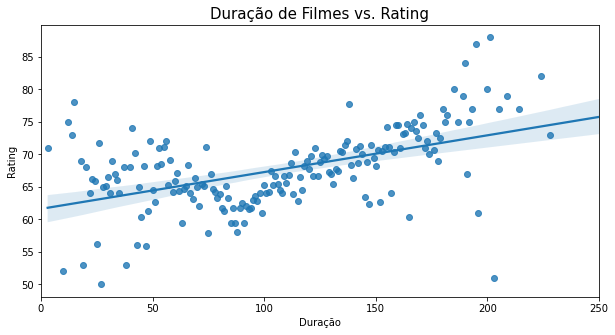

In [75]:
df_plot = utils.get_rating_by_element(df_min, "duration")

plt.figure(figsize=(10, 5))
sns.regplot(data=df_plot, x='duration', y="rating")
plt.title("Duração de Filmes vs. Rating", fontsize=15)
plt.xlabel("Duração")
plt.xlim(0, 250)
plt.ylabel("Rating")
plt.show()

In [76]:
scaler = MinMaxScaler()
df_min["duration"] = scaler.fit_transform(df_min[["duration"]])

In [77]:
# Concatenação dos dois datasets
list_index = df_min.index.values.tolist() + df_season.index.values.tolist()
df_other = df_eda[~df_eda.index.isin(list_index)]
df_eda = pd.concat([df_min, df_season, df_other])

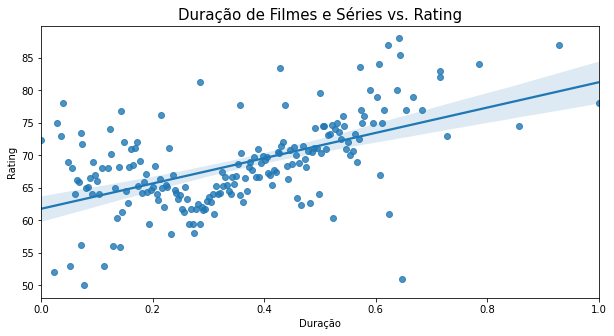

In [78]:
df_plot = utils.get_rating_by_element(df_eda, "duration")

plt.figure(figsize=(10, 5))
sns.regplot(data=df_plot, x='duration', y="rating")
plt.title("Duração de Filmes e Séries vs. Rating", fontsize=15)
plt.xlabel("Duração")
# plt.xlim(0, 250)
plt.ylabel("Rating")
plt.show()

<a id="type"></a>
## 3.3. Type

Para a variável de tipo, apenas uma conversão binária é suficiente. Em média, as séries são mais bem avaliadas do que os filmes, como podemos ver na tabela abaixo.

In [79]:
df_plot = utils.get_rating_by_element(df_eda, "type")
df_plot

,type,rating
0,Movie,65.085190
1,TV Show,73.616062


In [80]:
# Substitui strings por valores 0 e 1
df_eda['type'].replace(['TV Show','Movie'],[0,1],inplace=True)

<a id="country"></a>
## 3.4. Country

Como vimos anteriormente, a variável "country" pode ter vários países na mesma célula. Portanto, é necessário separá-los para ter uma avaliação de cada um de forma isolada.

No gráfico abaixo, conseguimos concluir que existe claramente uma avaliação diferente em cada país. Eu considerei países que tem, pelo menos, 5 avaliações para que pudesse formar uma nova coluna.

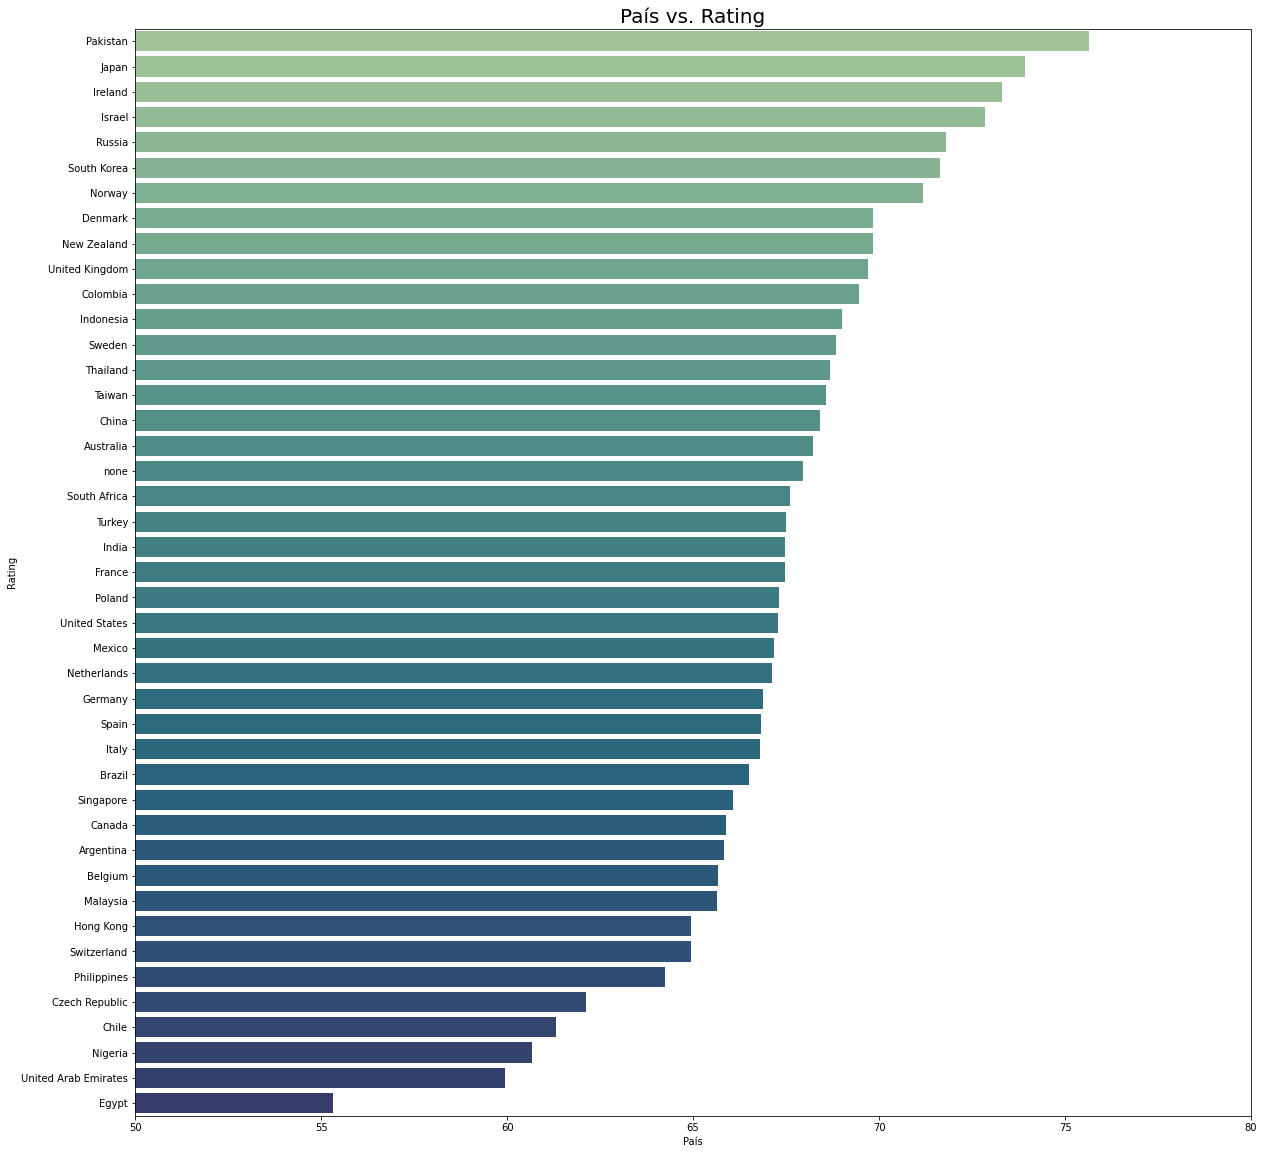

In [81]:
# Essa função retorna dois dataframes, sendo que o primeiro possui as novas colunas de países
# e o segundo possui os países separados com o valor da avaliação média
df_eda, df_country = utils.split_column(df_eda, 'country', min_frequency=10)

plt.figure(figsize = (20,20))
sns.barplot(df_country["rating"],df_country["country"], orient = 'h', palette="crest")
plt.xlim(50, 80)
plt.title("País vs. Rating", fontsize=20)
plt.ylabel("Rating")
plt.xlabel("País")
plt.show()

<a id="genre"></a>
## 3.5. Listed/Genre

Para o gênero, a mesma ideia. Aqui podemos observar que os filmes/series clássicos são o top 1, seguidos de alguns gêneros mais infantis. Ao contrário, filmes e séries de terror tem uma avaliação baixa. 

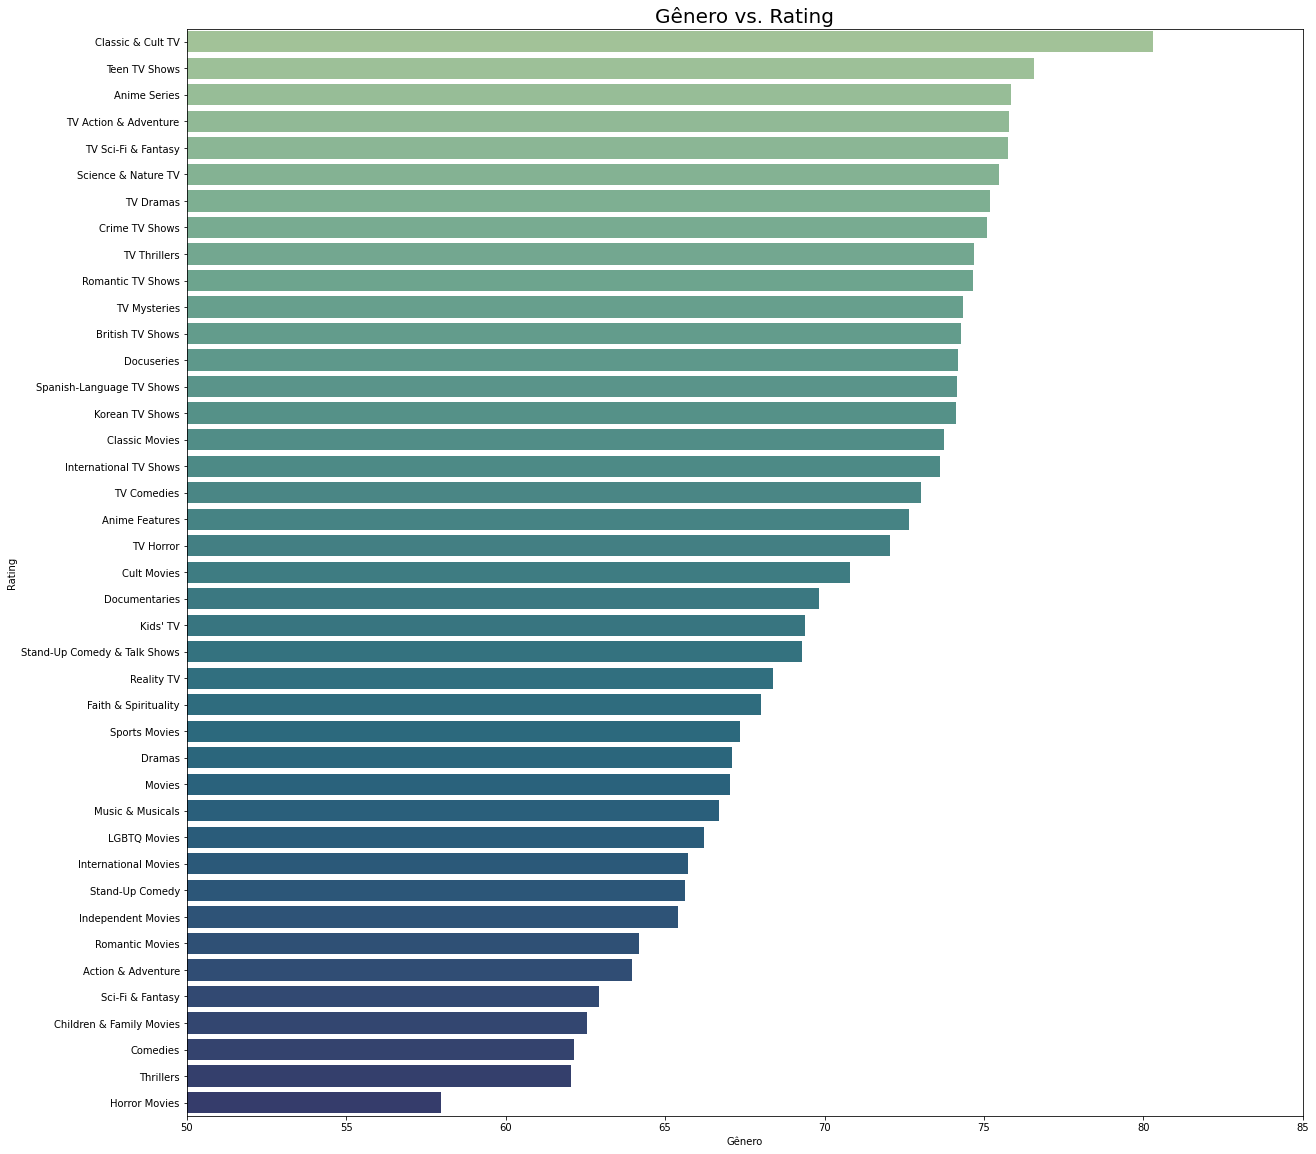

In [82]:
df_eda, df_listed_in = utils.split_column(df_eda, 'listed_in', 10)

plt.figure(figsize = (20, 20))
sns.barplot(df_listed_in["rating"],df_listed_in["listed_in"], orient = 'h', palette="crest")
plt.xlim(50,85)
plt.title("Gênero vs. Rating", fontsize=20)
plt.ylabel("Rating")
plt.xlabel("Gênero")
plt.show()

<a id="director"></a>
## 3.6. Director

Como o número de filmes por diretor, em média, é bem mais baixo que o número de filmes por gênero ou por país, considerei apenas 5 filmes para que um diretor fosse considerado uma nova coluna.

Novamente, o diretor certamente influencia na avaliação. Grandes diretores aparecem entre os primeiros: Quentin Tarantino,  Steven Spielberg e Martin Scorsese.

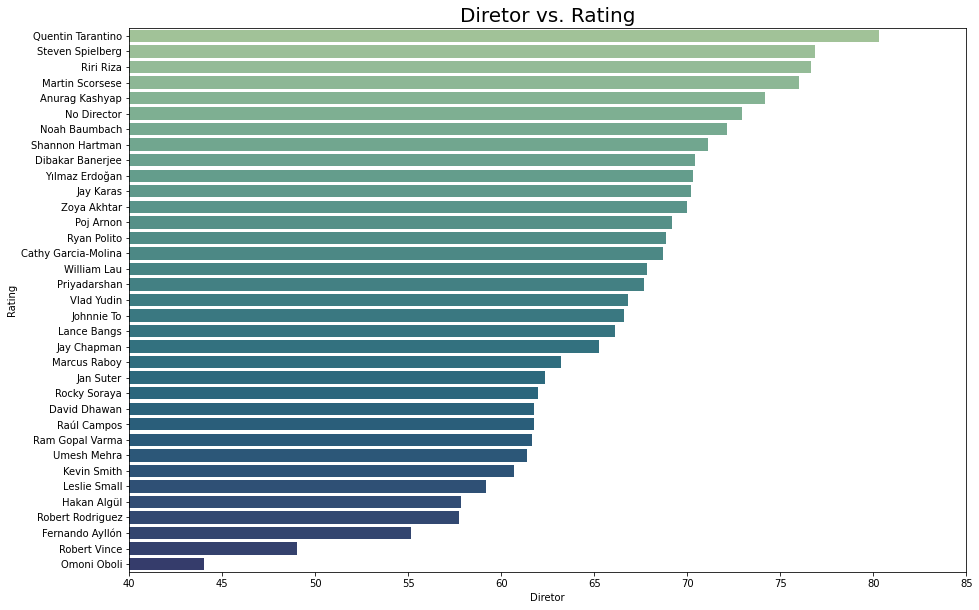

In [83]:
df_eda, df_director = utils.split_column(df_eda, 'director', 5)

plt.figure(figsize = (15, 10))
sns.barplot(df_director["rating"],df_director["director"], orient = 'h', palette="crest")
plt.xlim(40,85)
plt.title("Diretor vs. Rating", fontsize=20)
plt.ylabel("Rating")
plt.xlabel("Diretor")
plt.show()

Podemos fazer uma outra análise com essa variável: será que diretores com mais filmes tem melhores avaliações? Talvez diretores com mais filmes podem ter maior popularidade e, portanto, receber avaliações mais positivas.

Porém, dado o gráfico abaixo, as duas coisas não tem correlação.

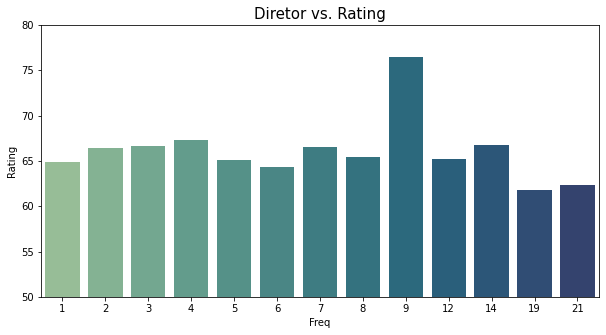

In [84]:
df_plot = df_eda[df_eda["director"] != "No Director"]
df_plot = utils.get_rating_by_frequency(df_plot, "director")

plt.figure(figsize = (10, 5))
sns.barplot(y=df_plot["rating"], x=df_plot.index, orient = 'v', palette="crest")
plt.ylim(50, 80)
plt.title("Diretor vs. Rating", fontsize=15)
plt.ylabel("Rating")
plt.xlabel("Freq")
plt.show()

<a id="cast"></a>
## 3.7. Cast

Podemos fazer as mesmas análises com a variável de elenco. Conforme os gráficos abaixo, as estrelas claramente fazem a diferença na avaliação final.

Além disso, a quantidade de filmes realizados também não faz muita diferença.

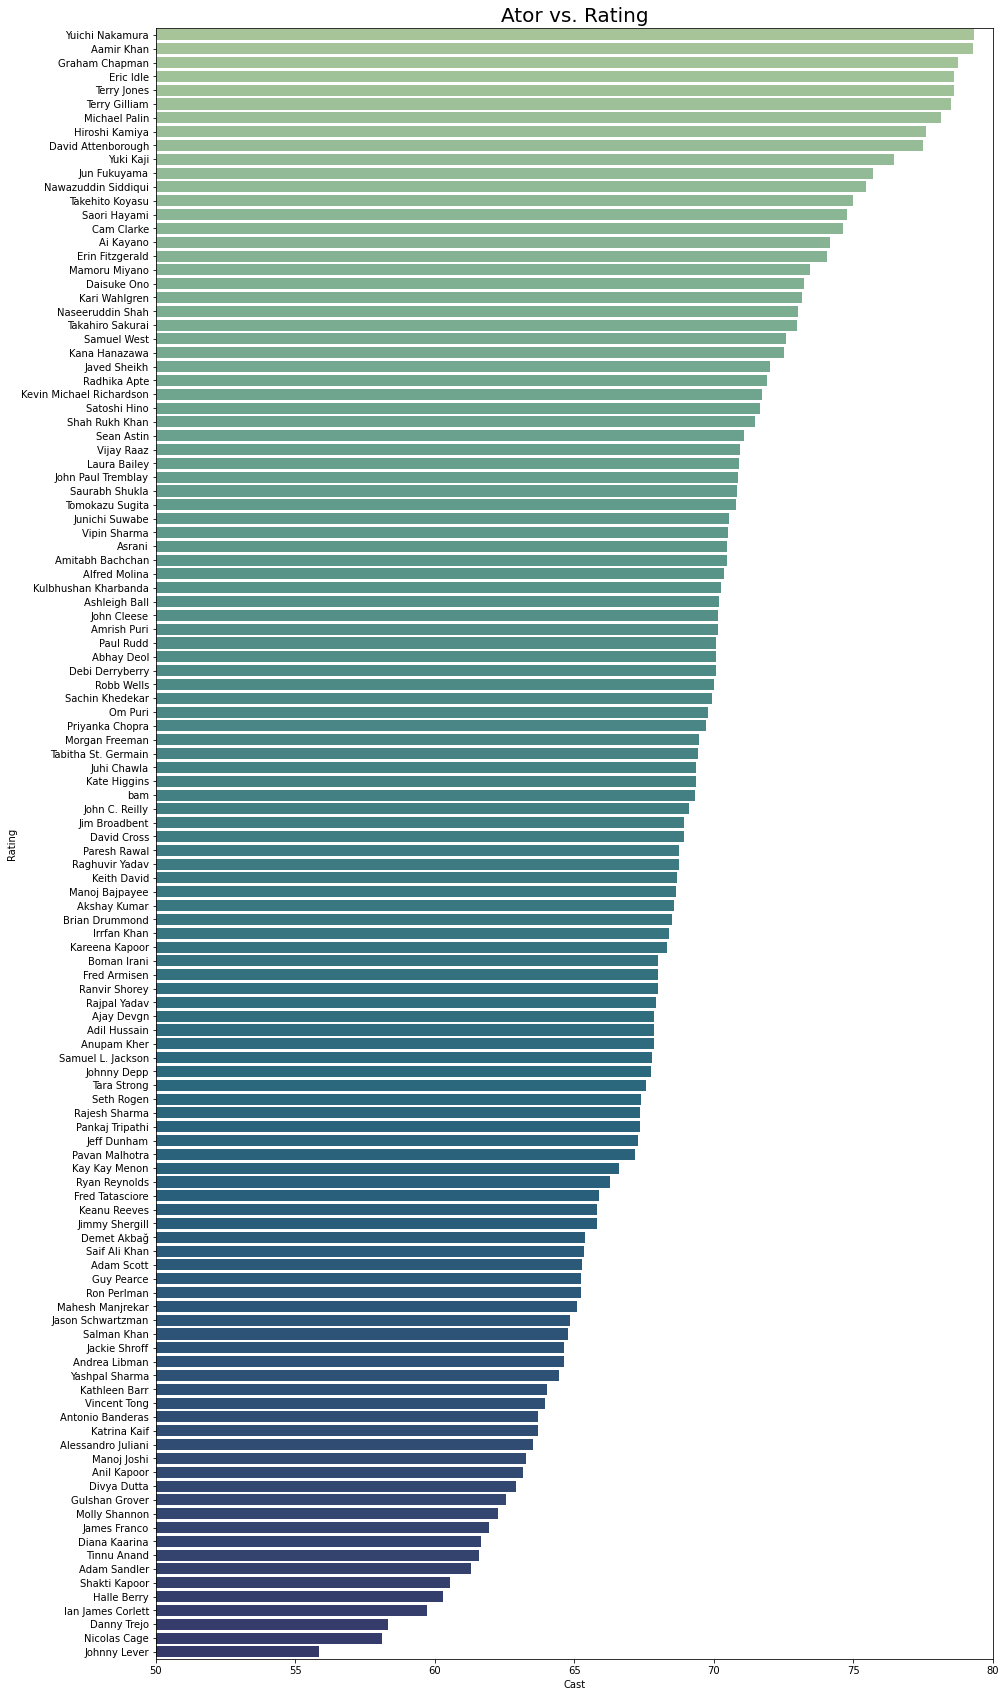

In [85]:
df_eda, df_cast = utils.split_column(df_eda, 'cast', 10)

plt.figure(figsize = (15, 30))
sns.barplot(df_cast["rating"],df_cast["cast"], orient = 'h', palette="crest")
plt.xlim(50,80)
plt.title("Ator vs. Rating", fontsize=20)
plt.ylabel("Rating")
plt.xlabel("Cast")
plt.show()

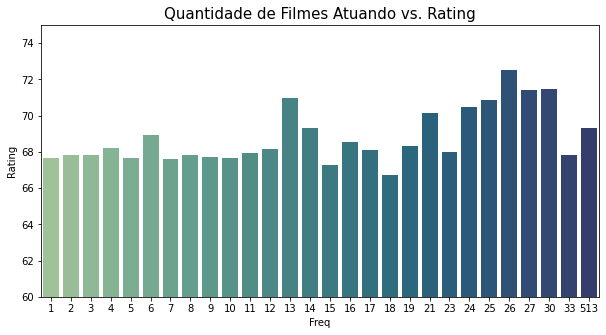

In [86]:
df_plot = utils.get_rating_by_frequency(df_eda, "cast")

plt.figure(figsize = (10, 5))
sns.barplot(y=df_plot["rating"], x=df_plot.index, orient = 'v', palette="crest")
plt.ylim(60,75)
plt.title("Quantidade de Filmes Atuando vs. Rating", fontsize=15)
plt.ylabel("Rating")
plt.xlabel("Freq")
plt.show()

<a id="release"></a>
## 3.8. Release Year & Date Added

Como já mencionei anteriormente, é bem provável que os filmes antigos tenham boas avaliações. NO gráfico abaixo temos mais um argumento para isso. Apesar de os filmes lançados entre 1940 e 1980 terem uma dispersão bastante alta, conseguimos observar uma queda nas avaliações dos filmes lançados desde a década de 80.

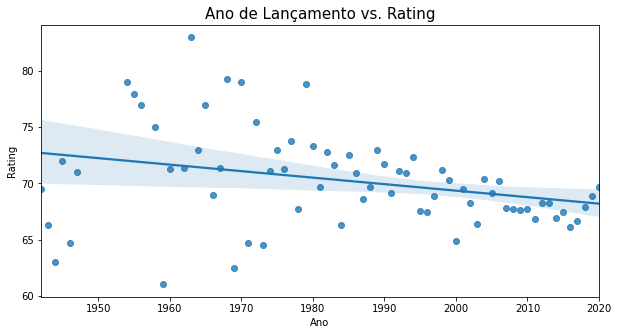

In [87]:
df_plot = utils.get_rating_by_element(df_eda, "release_year")

plt.figure(figsize=(10, 5))
sns.regplot(data=df_plot, x='release_year', y="rating")
plt.title("Ano de Lançamento vs. Rating", fontsize=15)
plt.xlabel("Ano")
plt.ylabel("Rating")
plt.show()

Podemos, ainda, criar uma outra variável: a diferença de anos entre a data de lançamento e a data que foi adicionado ao Netflix. 

A ideia aqui é comparar, por exemplo, um filme que foi lançado em 2000 e catalogado no Netflix em 2010, com um filme lançado em 2010 e catalogado em 2020.

Como podemos observar no gráfico abaixo, temos uma relação melhor das variáveis.

In [88]:
df_eda['year_added'], df_eda['month_added'] = df_eda['date_added'].dt.year, df_eda['date_added'].dt.month
df_eda["year_diff"] =  df_eda["year_added"] - df_eda["release_year"]

In [89]:
# Em oito casos temos filmes com valores negativos como é impossível um filme ser colocado no Netflix 
# antes de ser lançado, preenchi os valores com zeros
print(f"{len(df_eda[df_eda.year_diff < 0])} filmes com valores negativos")
df_eda.loc[df_eda['year_diff'] < 0, 'year_diff'] = 0

8 filmes com valores negativos


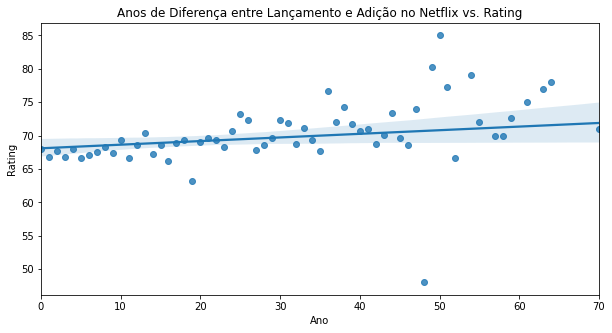

In [90]:
df_plot = utils.get_rating_by_element(df_eda, "year_diff")

plt.figure(figsize=(10, 5))
sns.regplot(data=df_plot, x='year_diff', y="rating")
plt.title("Anos de Diferença entre Lançamento e Adição no Netflix vs. Rating")
plt.xlabel("Ano")
plt.xlim(0, 70)
plt.ylabel("Rating")
plt.show()

<a id="title"></a>
## 3.9. Title & Description

Para as variáveis de Título e Descrição dos filmes precisamos ter uma abordagem diferente. Uma vez que estamos lidando com textos, o ideal é extrair um sentimento destes. Com a função abaixo, conseguimos calcular um score de um determinado texto e analisar se ele é positivo, negativo ou neutro. Além disso, a função também calcula um score composto de todos esses sentimentos.

In [91]:
def get_sentiment(df, col):
    results = []
    for headline in df[col]:
        scores = SIA().polarity_scores(headline) 
        scores['headline'] = headline
        results.append(scores)

    for sentiment in ["neg", "neu", "pos", 'compound']:
        df[col + "_" + sentiment] = pd.DataFrame(results)[sentiment]
        
    return df

def plot_sentiment_features(col, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

    fig.suptitle(title, fontsize=20)

    ax1.scatter(df_eda[col + "_pos"], df_eda["rating"], color="green")
    ax1.set_title('Positivo')

    ax2.scatter(df_eda[col + "_neg"], df_eda["rating"], color="red")
    ax2.set_title('Negativo')

    ax3.scatter(df_eda[col + "_neu"], df_eda["rating"], color="grey")
    ax3.set_title('Neutro')

    ax4.scatter(df_eda[col + "_compound"], df_eda["rating"], color="yellow")
    ax4.set_title('Composto')

    for ax in fig.get_axes():
        ax.label_outer()

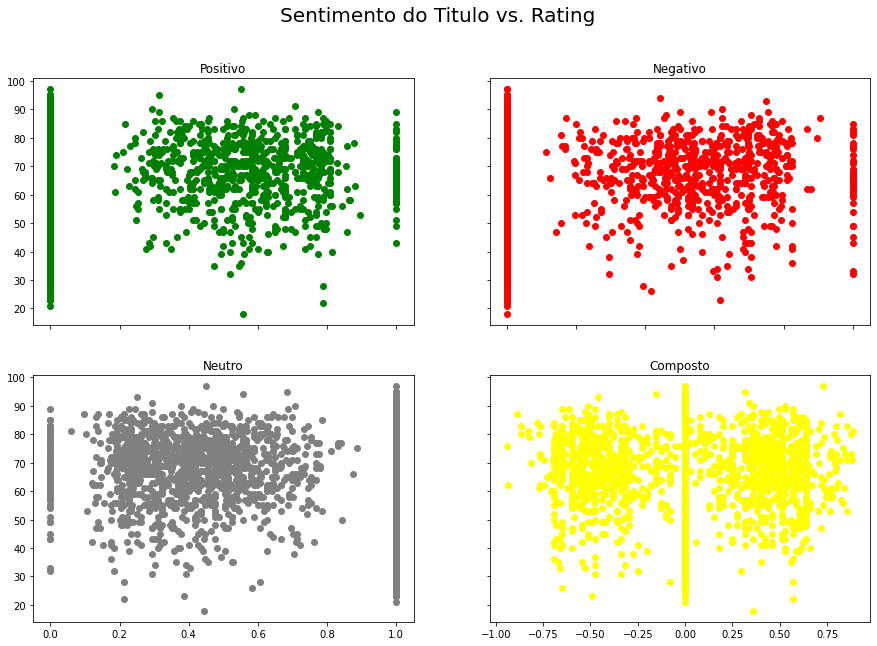

In [92]:
df_eda = get_sentiment(df_eda, "title")
plot_sentiment_features("title", "Sentimento do Titulo vs. Rating")

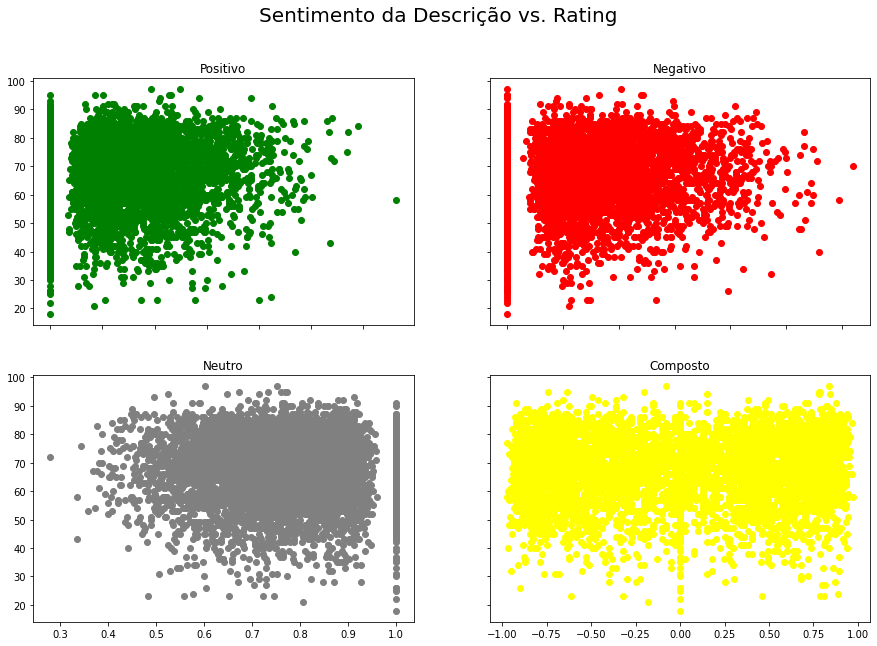

In [93]:
df_eda = get_sentiment(df_eda, "description")
plot_sentiment_features("description", "Sentimento da Descrição vs. Rating")

No caso do score composto, tanto para a variável título quanto para a variável descrição, uma vez que existe uma simetria que prejudica a correlação, vou deixar os valores dessa coluna em módulo.

In [94]:
# Conversão das variáveis em valores absolutos
df_eda["description_compound"] = df_eda["description_compound"].abs()
df_eda["title_compound"] = df_eda["title_compound"].abs()

# Substituição dos valores faltantes pela mediana
df_eda = df_eda.fillna(df_eda.median())

<a id="remocao"></a>
# 4. Remoção de Variáveis

Agora é necessário remover as variáveis das quais criamos outras colunas, além das variáveis de data.

Por fim, normalizamos a variável "year_diff", uma vez que todas as outras variáveis estão em uma escala de 0 a 1. Dessa forma, a variável não tem um peso diferente das outras na hora da modelagem.

In [95]:
# Remoção de variáveis
list_drop = ["country", "listed_in", "director", "cast", "description", "title", 
             "date_added", "release_year", "month_added", "year_added"]
df_eda.drop(list_drop, axis=1, inplace=True)

# Normalização
scaler = MinMaxScaler()
df_eda["year_diff"] = scaler.fit_transform(df_eda[["year_diff"]])

# Análise do dataset final
df_eda.head()

,show_id,type,rating,duration,country_United States,country_India,country_South Korea,country_China,country_United Kingdom,country_Spain,country_Canada,country_Chile,country_Denmark,country_Sweden,country_Netherlands,country_Belgium,country_France,country_Thailand,country_none,country_Pakistan,country_Turkey,country_Brazil,country_Italy,country_Indonesia,country_Ireland,country_Hong Kong,country_Mexico,country_Argentina,country_Nigeria,country_Norway,country_Switzerland,country_United Arab Emirates,country_Japan,country_Russia,country_Israel,country_Germany,country_Australia,country_Egypt,country_Czech Republic,country_Malaysia,country_South Africa,country_Philippines,country_Poland,country_Colombia,country_Singapore,country_New Zealand,country_Taiwan,listed_in_Children & Family Movies,listed_in_Comedies,listed_in_Stand-Up Comedy,listed_in_International Movies,listed_in_Sci-Fi & Fantasy,listed_in_Thrillers,listed_in_Action & Adventure,listed_in_Dramas,listed_in_Cult Movies,listed_in_Independent Movies,listed_in_Romantic Movies,listed_in_Documentaries,listed_in_Horror Movies,listed_in_Music & Musicals,listed_in_Anime Features,listed_in_Faith & Spirituality,listed_in_LGBTQ Movies,listed_in_Movies,listed_in_Classic Movies,listed_in_Sports Movies,listed_in_Kids' TV,listed_in_Crime TV Shows,listed_in_International TV Shows,listed_in_Spanish-Language TV Shows,listed_in_Docuseries,listed_in_Science & Nature TV,listed_in_Romantic TV Shows,listed_in_TV Comedies,listed_in_TV Dramas,listed_in_TV Thrillers,listed_in_TV Mysteries,listed_in_British TV Shows,listed_in_Reality TV,listed_in_TV Action & Adventure,listed_in_Teen TV Shows,listed_in_Korean TV Shows,listed_in_Anime Series,listed_in_TV Horror,listed_in_Stand-Up Comedy & Talk Shows,listed_in_TV Sci-Fi & Fantasy,listed_in_Classic & Cult TV,director_No Director,director_William Lau,director_Rocky Soraya,director_Riri Riza,director_Poj Arnon,director_Umesh Mehra,director_Jay Chapman,director_Ryan Polito,director_Robert Vince,director_Vlad Yudin,director_Quentin Tarantino,director_Noah Baumbach,director_Priyadarshan,director_Jay Karas,director_Omoni Oboli,director_Yılmaz Erdoğan,director_Ram Gopal Varma,director_Jan Suter,director_Hakan Algül,director_Martin Scorsese,director_Robert Rodriguez,director_Anurag Kashyap,director_Leslie Small,director_Shannon Hartman,director_Kevin Smith,director_Marcus Raboy,director_Steven Spielberg,director_Lance Bangs,director_Raúl Campos,director_Dibakar Banerjee,director_Fernando Ayllón,director_David Dhawan,director_Zoya Akhtar,director_Cathy Garcia-Molina,director_Johnnie To,cast_Antonio Banderas,cast_James Franco,cast_Ron Perlman,cast_bam,cast_Nicolas Cage,cast_David Cross,cast_Aamir Khan,cast_Saurabh Shukla,cast_Boman Irani,cast_Laura Bailey,cast_Guy Pearce,cast_Akshay Kumar,cast_Jeff Dunham,cast_John Paul Tremblay,cast_Robb Wells,cast_Keanu Reeves,cast_Adil Hussain,cast_Jason Schwartzman,cast_Danny Trejo,cast_Rajesh Sharma,cast_Demet Akbağ,cast_Ryan Reynolds,cast_Samuel L. Jackson,cast_Molly Shannon,cast_Seth Rogen,cast_Adam Sandler,cast_Naseeruddin Shah,cast_John C. Reilly,cast_Jackie Shroff,cast_Gulshan Grover,cast_Takahiro Sakurai,cast_Yuki Kaji,cast_Yuichi Nakamura,cast_Adam Scott,cast_Shakti Kapoor,cast_Amrish Puri,cast_Satoshi Hino,cast_Saori Hayami,cast_Cam Clarke,cast_Kari Wahlgren,cast_Sean Astin,cast_Kevin Michael Richardson,cast_Vincent Tong,cast_Andrea Libman,cast_Alessandro Juliani,cast_Diana Kaarina,cast_Ian James Corlett,cast_Kathleen Barr,cast_Fred Tatasciore,cast_Juhi Chawla,cast_Jimmy Shergill,cast_Halle Berry,cast_Shah Rukh Khan,cast_Paresh Rawal,cast_Rajpal Yadav,cast_Manoj Joshi,cast_Asrani,cast_Katrina Kaif,cast_Anil Kapoor,cast_Javed Sheikh,cast_Tinnu Anand,cast_Salman Khan,cast_Mahesh Manjrekar,cast_John Cleese,cast_Terry Gilliam,cast_Eric Idle,cast_Terry Jones,cast_Michael Palin,cast_Graham Chapman,cast_Tara Strong,cast_Ajay Devgn,cast_Jim Broadbent,cast_Yashpal Sharma,cast_Kay Kay Menon,cast_Ranvir Shorey,cast_Vipin Sharma

In [96]:
# Chegamos a uma base com mais de 200 variáveis
df_eda.shape

(5903, 250)

<a id="correlacao"></a>
# 5. Correlação

Analisando a correlação das variáveis com o target, podemos observar que não existem correlações muito fortes, o que prejudicará na modelagem.

Podemos fazer um primeiro filtro dessas variáveis descartando aquelas que tem correlação absoluta abaixo de 0.05.

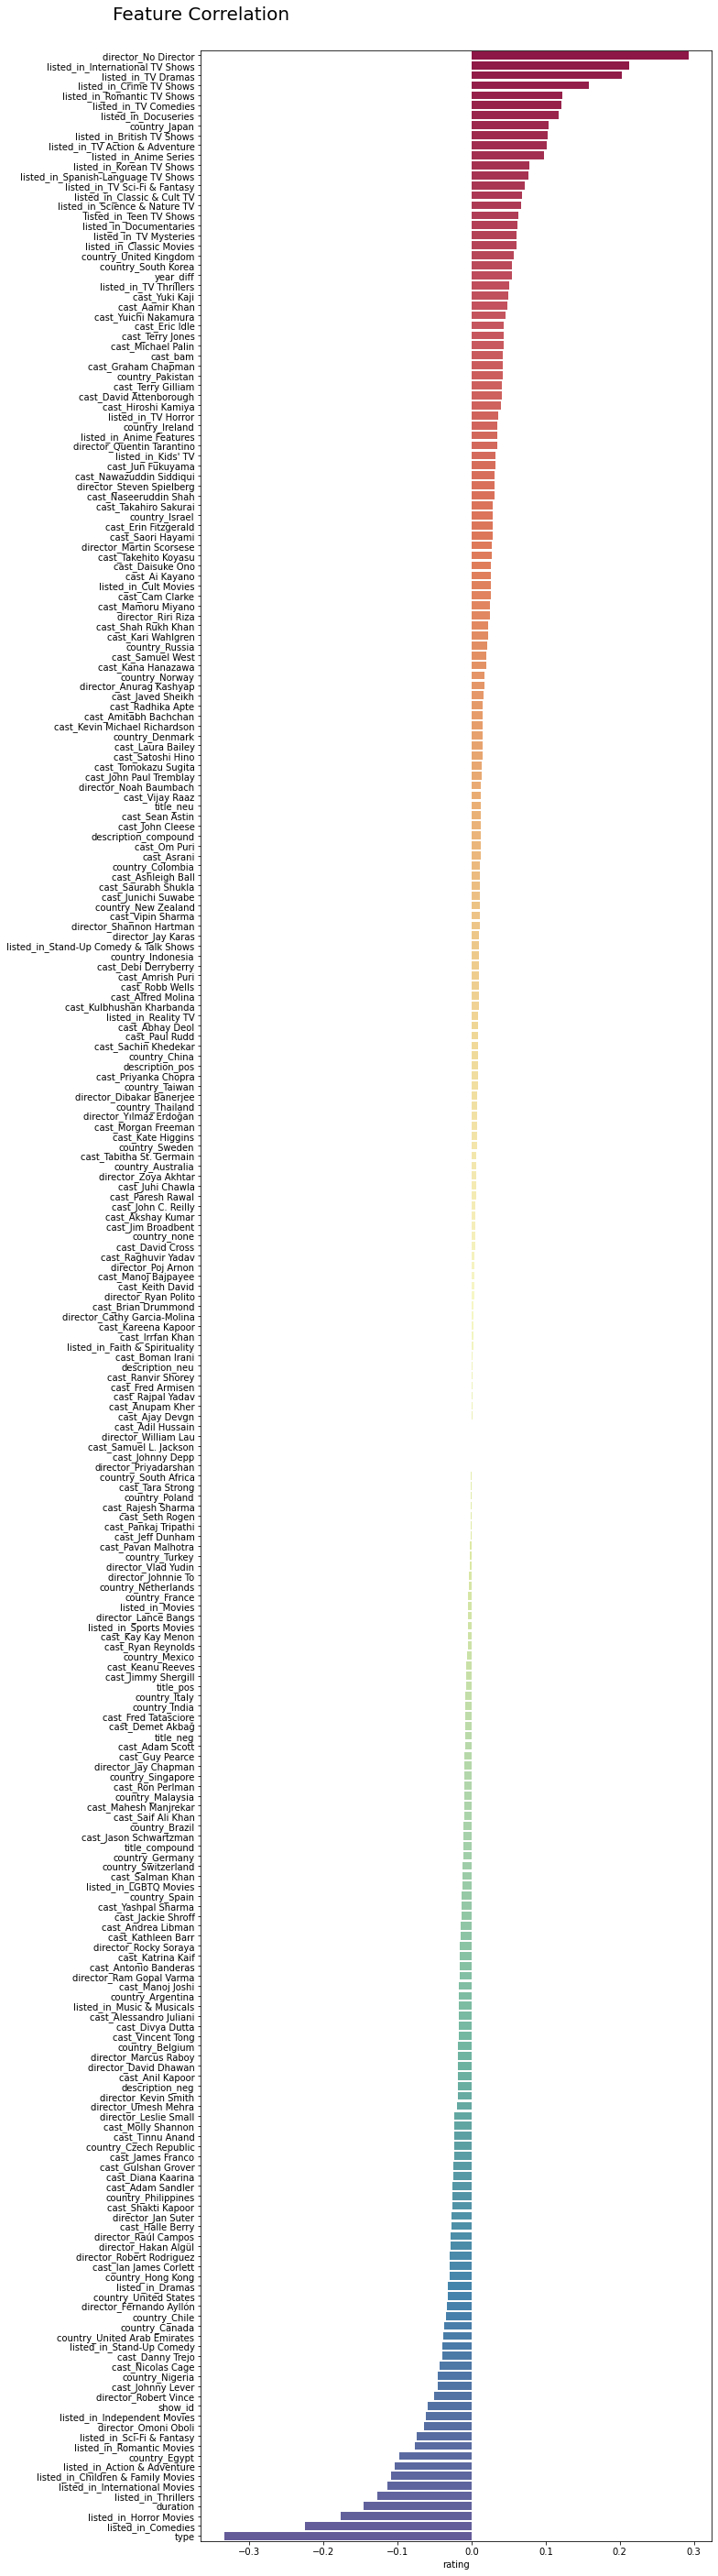

In [97]:
corr_mat = df_eda.astype(float).corr()
corr_mat_fil = corr_mat.loc[:, 'rating'].sort_values(ascending=False)
corr_mat_fil = pd.DataFrame(data=corr_mat_fil[1:])

plt.figure(figsize=(10,50))
bar = sns.barplot(x=corr_mat_fil.rating, y=corr_mat_fil.index, data=corr_mat_fil, palette="Spectral")
title = bar.set_title("Feature Correlation", x=0.0, y=1.01, size=20)

In [98]:
corr_val = 0.8
df_corr = df_eda.corr().unstack().reset_index()
df_corr = df_corr[(df_corr[0] > corr_val) &
                 ((df_corr[0] < 1))].rename(columns={"level_0":"v1", 
                                                     "level_1":"v2", 
                                                     0:"correlation"}).sort_values(by=["correlation"], ascending=False)
df_corr

,v1,v2,correlation
34137,cast_John Paul Tremblay,cast_Robb Wells,0.966010
34386,cast_Robb Wells,cast_John Paul Tremblay,0.966010
47688,cast_Michael Palin,cast_Eric Idle,0.963542
47190,cast_Eric Idle,cast_Michael Palin,0.963542
47689,cast_Michael Palin,cast_Terry Jones,0.963542
47440,cast_Terry Jones,cast_Michael Palin,0.963542
47437,cast_Terry Jones,cast_Terry Gilliam,0.960687
46938,cast_Terry Gilliam,cast_Eric Idle,0.960687
46939,cast_Terry Gilliam,cast_Terry Jones,0.960687
47187,cast_Eric Idle,cast_Terry Gilliam,0.960687


<a id="modelagem"></a>
# 6. Modelagem

<a id="split"></a>
## 6.1. Divisão do Dataset

In [99]:
X_train, X_test, y_train, y_test = train_test_split(df_eda, df_eda["rating"], test_size=0.2)
X_train.drop(["show_id", "rating"], axis=1,inplace=True)
X_test.drop(["show_id", "rating"], axis=1,inplace=True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4722, 248) (4722,)
(1181, 248) (1181,)


<a id="dimensionalidade"></a>
## 6.2. Redução de Dimensionalidade

Dado que temos quase 250 variáveis, aplicar redução de dimensionalidade pode ajudar na performance do modelo e também na redução de multicolinearidade.

O gráfico mostra que se reduzirmos o número de variáveis a 150, ainda conseguimos explicar mais de 80% da variância dos dados.

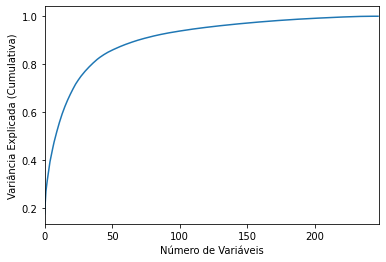

In [100]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, len(X_train.columns), 1)
plt.xlabel('Número de Variáveis')
plt.ylabel('Variância Explicada (Cumulativa)')
plt.show()

In [101]:
sklearn_pca = PCA(n_components=150)
X_train = sklearn_pca.fit_transform(X_train)
X_test = sklearn_pca.fit_transform(X_test)

<a id="previsao"></a>
## 6.3. Previsão

A princípio, eu havia escolhido alguns modelos lineares (como Regressão Linear, Lasso e Ridge), dada a linearidade de muitas das variáveis do problema. Depois acrescentei outros modelos mais robustos para comparar o comportamento e tentar buscar o menor erro.

In [102]:
dict_models = {'Linear Regression':linear_model.LinearRegression(),
               'Lasso': linear_model.Lasso(random_state=1),
               'Ridge': linear_model.BayesianRidge(),
               'SVM': svm.SVR(),
               'Decision Tree Regressor': tree.DecisionTreeRegressor(random_state=1),
               'KNN': neighbors.KNeighborsRegressor(5),
               'LGBM': LGBMRegressor(objective='regression', random_seed=1),
               'Random Forest Regressor': RandomForestRegressor(random_state=1),
               'XGB': xgb.XGBRegressor(),
               'Gradient Boosting': GradientBoostingRegressor(random_state=1),
               'Cat Boost': CatBoostRegressor(verbose=False, random_seed=1)
              }

In [103]:
dict_results = {}
for item in dict_models:
    model = dict_models[item]
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    dict_results[item] = round(mean_absolute_error(y_test, predictions),2)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

<a id="resultados"></a>
# 7. Resultados

Chegamos a um erro médio absoluto de pouco menos de 9. É um resultado razoável, mas que tem muito potencial de melhora dada a quantidade de informação que temos e o quanto ainda podemos ter.

In [104]:
df_results = pd.DataFrame(dict_results.items(), columns=['Model', 'MAE']).sort_values(by="MAE")
df_results

,Model,MAE
1,Lasso,8.98
3,SVM,9.07
7,Random Forest Regressor,9.11
10,Cat Boost,9.14
6,LGBM,9.19
9,Gradient Boosting,9.24
2,Ridge,9.89
8,XGB,10.00
0,Linear Regression,10.05
5,KNN,10.31


<a id="otimizacao"></a>
# 8. Otimização de Hiperparâmetros

Para tentar buscar um erro ainda menor, podemos fazer um Grid Search no modelo que teve melhor desempenho. Aqui temos apenas um pequeno exemplo e que já reduz o erro do modelo CatBoost.

In [105]:
depth = [6, 8, 10]
learning_rate = [0.01, 0.1]
iterations = [50, 100]
best_mae = 10

for d in depth:
    for l in learning_rate:
        for i in iterations:
            model = CatBoostRegressor(depth=d, learning_rate=l, iterations=i, verbose=False, random_seed=1)
            model = model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            mae = mean_absolute_error(y_test, predictions)
            if mae < best_mae:
                best_mae = mae
                print(mae)

9.101072487272205
8.962812761216442
8.933636592151817


<a id="melhorias"></a>
# 9. Possíveis Melhorias

* Cross Validation
* Outras Métricas (RMSE, MAPE...)
* Modelos de Redes Neurais
* Métodos como Stacking ou Voting
* Buscar mais variáveis (encontrei uma base com variáveis relacionadas ao pais, está na pasta "data")